Always run the following 3 cells first.

In [1]:
from datasets.sequence_generator import generate_examples

import argparse

import torch.nn as nn
import torch

import harvard_transformer as tr
from torch.autograd import Variable

import matplotlib.pyplot as plt
import numpy as np

import intrinsic_dimension as idims

from sklearn.decomposition import PCA

from manifold_analysis.manifold_analysis_correlation import manifold_analysis_corr


In [2]:
##### DATA PARAMETERS #####
dataset_file = "alphabet_explicit_singular_data.txt"
vocabulary_file = 'datasets/alphabet_explicit.txt'
operation_type = 'singular'
transition_type = 'explicit'

##### MODEL PARAMETERS #####
num_layers = 2
num_heads = 4
hidden_size = 16 # The hidden size MUST be divisible by the number of heads and even
model_save = 'truealphabet_transformer_hid_'+str(hidden_size)+'_heads_'+str(num_heads)+'_lyrs_'+str(num_layers)+'.mdl'

##### TRAINING PARAMETERS #####
batch_size = 24
num_batches = 100
num_epochs = 100
print_frequency = 10

In [3]:
def cosine_similarity(a,b):
    return np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))

def data_generator(vocabulary, batch_size, num_batches, Ks=[2,4,5,7]):
    "Generate random data for a src-tgt copy task."
    for btch in range(num_batches):
        selected_ks = np.random.choice(Ks, batch_size)

        pad = len(vocabulary)
        srcs = []
        tgts = []
        for lk in selected_ks:
            output = generate_examples(transition_type = transition_type, \
                                        operation_type = operation_type, \
                                        vocabulary = vocabulary, \
                                        k = lk, \
                                        num_examples=1).strip()

            training_line, target = output.split(';')
            training_sequence = training_line.split(' ')

            src = []
            for char in training_sequence:
                src.append(vocabulary.index(char))

            for padding_char in range(20 - len(training_sequence)):
                src.append(pad)

            tgt = [pad, vocabulary.index(target)]
            # for padding_char in range(20 - len(tgt)):
            #     tgt.append(pad)

            srcs.append(src)
            tgts.append(tgt)

        srcs = torch.from_numpy(np.array(srcs))
        tgts = torch.from_numpy(np.array(tgts))

        # data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        # data[:, 0] = 1
        srcs = Variable(srcs, requires_grad=False)
        tgts = Variable(tgts, requires_grad=False)
        # import pdb; pdb.set_trace()

        yield tr.Batch(srcs, tgts, pad)

def data_sample(vocabulary, Ks=[2,4,5,7], verbose=False):
    "Generate random data for a src-tgt copy task."
    pad = len(vocabulary)
    output = generate_examples(transition_type = transition_type, \
                               operation_type = operation_type, \
                               vocabulary = vocabulary, \
                               k = np.random.choice(Ks), \
                               num_examples=1).strip()

    training_line, target = output.split(';')
    training_sequence = training_line.split(' ')

    src = []
    for char in training_sequence:
        src.append(vocabulary.index(char))

    for padding_char in range(20 - len(training_sequence)):
        src.append(pad)

    tgt = [pad, vocabulary.index(target)]
            # for padding_char in range(20 - len(tgt)):
            #     tgt.append(pad)

    src = Variable(torch.from_numpy(np.array(src)), requires_grad=False)
    tgt = Variable(torch.from_numpy(np.array(tgt)), requires_grad=False)
        # import pdb; pdb.set_trace()
    if verbose:
        if transition_type == 'explicit':
            split_idx = training_sequence.index('|')
            remember = training_sequence[:split_idx]
            forget = training_sequence[split_idx+1:]
        return src.reshape(1,-1), tgt, len(remember), remember, forget
    return src, tgt

def generate_data_from_source(source):
    remember, forget = source.split('|')
    remember = remember.lstrip().strip().split(' ')
    forget = forget.lstrip().strip().split(' ')
    
    target = list(set(remember).difference(set(forget)))[0]
    tgt = [vocabulary.index(target)]
    
    k = len(remember)
    
    line = source.lstrip().strip().split(' ')
    
    src = []
    for token in line:
        src.append(vocabulary.index(token))
    
    src = src + [len(vocabulary)]*(20 - len(src))
    tgt = [len(vocabulary)]+tgt
    
    src = torch.Tensor(src).reshape(1,-1).long()
    tgt = torch.Tensor(tgt).long()
    
    return src,tgt, k, remember, forget

vocabulary = []
with open(vocabulary_file) as file:
    for line in file:
        vocabulary.append(line.strip())

def set_color_cycle():
    cm = plt.get_cmap('gist_rainbow')
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_prop_cycle(color=[cm(1.*i/len(vocabulary)) for i in range(len(vocabulary))])
    
    return fig, ax

The following cell only loads the model. If the parameters specified prebiously describe the model you wish to load then run this following cell to load the model into memory.

In [4]:
##### LOAD MODEL #####
model = tr.make_transformer(src_vocab=len(vocabulary)+1, \
                        tgt_vocab=len(vocabulary)+1, \
                        N=num_layers, \
                        d_model=hidden_size, \
                        d_ff=4*hidden_size, \
                        h=num_heads, \
                        dropout=0.0)
model.load_state_dict(torch.load(model_save))

The following cell trains a new model using the parameters set above. The model will be save ever `print_frequency` epochs under the name set in `model_save`

In [48]:
##### TRAIN MODEL #####
model = tr.make_transformer(src_vocab=len(vocabulary)+1, \
                        tgt_vocab=len(vocabulary)+1, \
                        N=num_layers, \
                        d_model=hidden_size, \
                        d_ff=4*hidden_size, \
                        h=num_heads, \
                        dropout=0.0)

criterion = nn.CrossEntropyLoss()

model_opt = tr.NoamOpt(model.src_embed[0].d_model, 1, 400,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
print('Training Transformer')
for epoch in range(num_epochs):
    model.train()
    tr.run_epoch(data_generator(vocabulary, batch_size, num_batches), \
                model, \
              tr.SimpleLossCompute(model.generator, criterion, model_opt))
    
    if (epoch + 1) % print_frequency == 0:
        print('Epoch::'+str(epoch+1))
        model.eval()
        print(tr.run_epoch(data_generator(vocabulary, batch_size, 1), \
                    model, \
                  tr.SimpleLossCompute(model.generator, criterion, None)))
        torch.save(model.state_dict(), model_save)

Training Transformer
Epoch::10
0.07510484755039215
Epoch::20
0.04483747482299805
Epoch::30
0.02766621857881546
Epoch::40
0.028786929324269295
Epoch::50
0.01690886728465557
Epoch::60
0.011799662373960018
Epoch::70
0.005436346400529146
Epoch::80
0.022141553461551666
Epoch::90
0.005484814289957285
Epoch::100
0.009633640758693218


The following cell tests the model. Be sure to have either a model trained or loaded using one of the previous cells. 

In [49]:
##### TEST MODEL #####
model.eval()
for k in range(2,11):
    correct = 0
    for ex in range(2000):
        src, tgt = data_sample(vocabulary, Ks=[k])
        src = src.reshape(1,-1)
        true = tgt[1].item()
        
        src_mask = (src != len(vocabulary)).unsqueeze(-2)
        out = tr.greedy_decode(model, src, src_mask, max_len=2, start_symbol=len(vocabulary))
        
        pred = out[0][1].item()

        # print(pred, true)
        if pred == true:
            # print('CORR')
            correct += 1
    # import pdb; pdb.set_trace()
    print('Dataset L'+str(k)+' Accuracy: '+str(round(correct/2000*100, 2)) + '%')


Dataset L2 Accuracy: 100.0%
Dataset L3 Accuracy: 99.3%
Dataset L4 Accuracy: 96.55%
Dataset L5 Accuracy: 93.15%
Dataset L6 Accuracy: 88.15%
Dataset L7 Accuracy: 81.9%
Dataset L8 Accuracy: 73.35%
Dataset L9 Accuracy: 66.5%
Dataset L10 Accuracy: 60.9%


tensor([[25,  1,  2, 26,  2,  1, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
         27, 27]])
Encoder


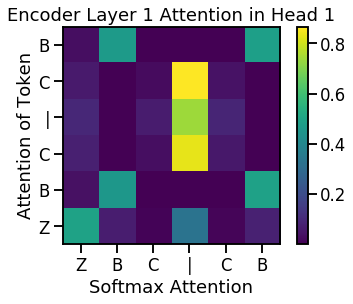

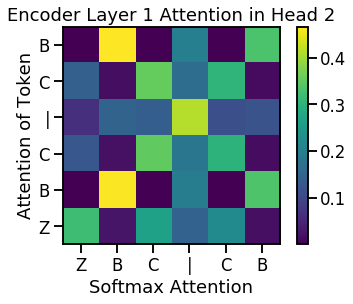

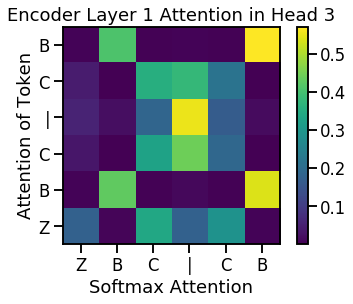

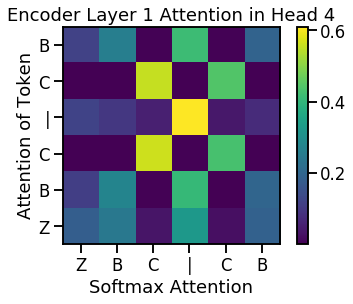

Encoder


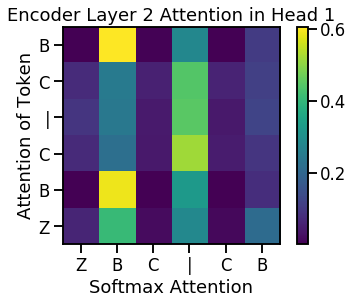

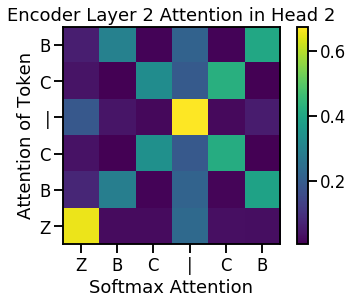

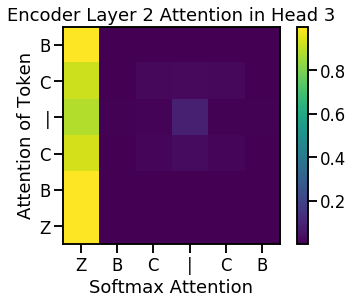

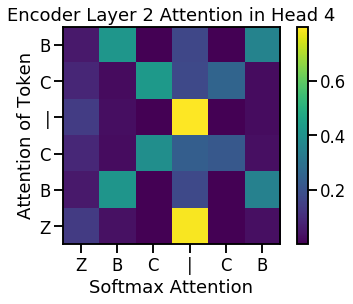

Decoder
SUM 1.0


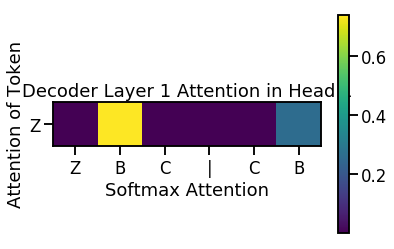

SUM 1.0


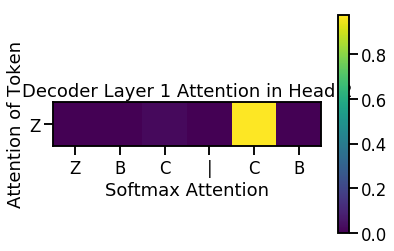

SUM 1.0


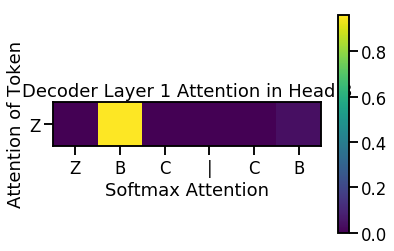

SUM 1.0


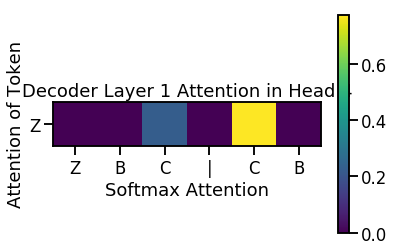

Decoder
SUM 1.0


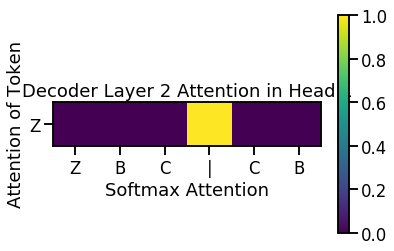

SUM 1.0


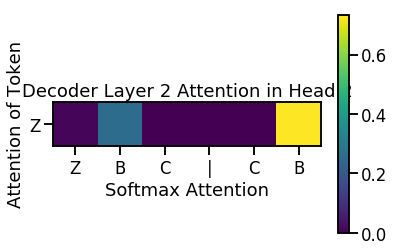

SUM 1.0


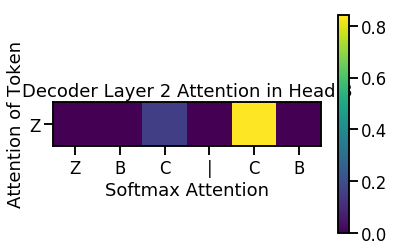

SUM 1.0


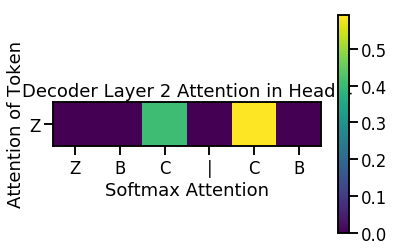

In [5]:
source_text = 'Z B C | C B'
src, tgt, k, remember_text, forget_text = generate_data_from_source(source_text)
print(src)
model.eval()

if transition_type == 'explicit' or transition_type == 'repeated':
    src_length = 2*k
else:
    src_length = 2*k - 1
        
true = tgt[1].item()
        
src_mask = (src != len(vocabulary)).unsqueeze(-2)
out = tr.greedy_decode(model, src, src_mask, max_len=2, start_symbol=len(vocabulary))

encoder_output = model.encode(src, src_mask)

pred = vocabulary[out[0][1].item()]
    
encoder_layers = model.encoder.layers
for lyr, encoder in enumerate(encoder_layers):
    print('Encoder')
    for head in range(num_heads):
        plt.title('Encoder Layer '+str(lyr+1)+' Attention in Head '+str(head+1))
        plt.imshow(encoder.self_attn.attn[0,head,:src_length, :src_length].detach().numpy(), origin='lower')
        plt.xticks(range(src_length), list(source_text.split(' ')))
        plt.yticks(range(src_length), list(source_text.split(' ')))
        plt.ylabel('Attention of Token')
        plt.xlabel('Softmax Attention')
        plt.colorbar()
        plt.show()

decoder_layers = model.decoder.layers
for lyr, decoder in enumerate(decoder_layers):
    print('Decoder')
#     print(decoder.src_attn.attn.shape)
#     print(decoder.src_attn.attn[:,0,0, :src_length].detach().numpy())
    for head in range(num_heads):
        plt.title('Decoder Layer '+str(lyr+1)+' Attention in Head '+str(head+1))
        print('SUM',np.sum(decoder.src_attn.attn[:,head,0, :src_length].detach().numpy()))
        plt.imshow(decoder.src_attn.attn[:,head,0, :src_length].detach().numpy(), origin='lower')
        plt.xticks(range(src_length), list(source_text.split(' ')))
        plt.yticks(range(1), [vocabulary[tgt.numpy()[1]]])
        plt.ylabel('Attention of Token')
        plt.xlabel('Softmax Attention')
        plt.colorbar()
        plt.show()
    
# Dataset L2 Accuracy: 92.3%
# Dataset L3 Accuracy: 70.45%
# Dataset L4 Accuracy: 65.8%
# Dataset L5 Accuracy: 60.9%
# Dataset L6 Accuracy: 58.0%
# Dataset L7 Accuracy: 53.25%
# Dataset L8 Accuracy: 48.5%
# Dataset L9 Accuracy: 43.8%
# Dataset L10 Accuracy: 38.35%

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 26,  9,  8,  7,  6,  5,  4,  3,
          2,  1]])
Encoder


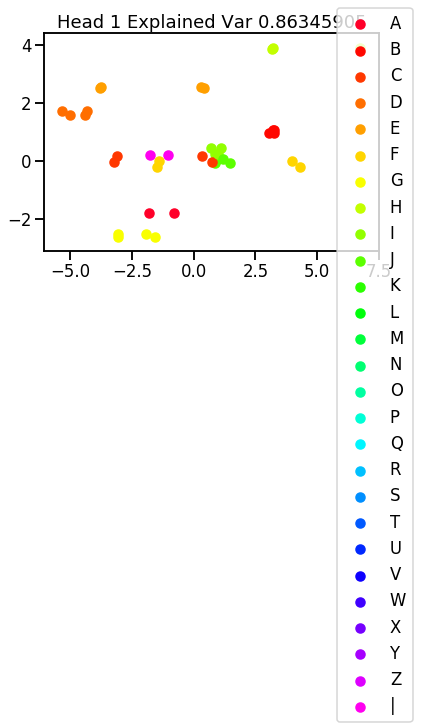

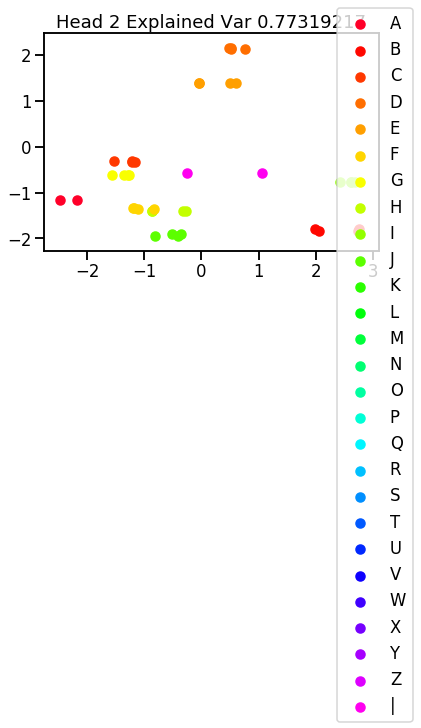

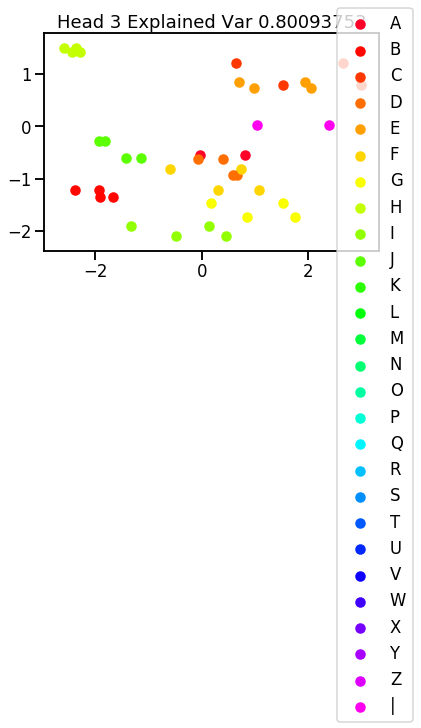

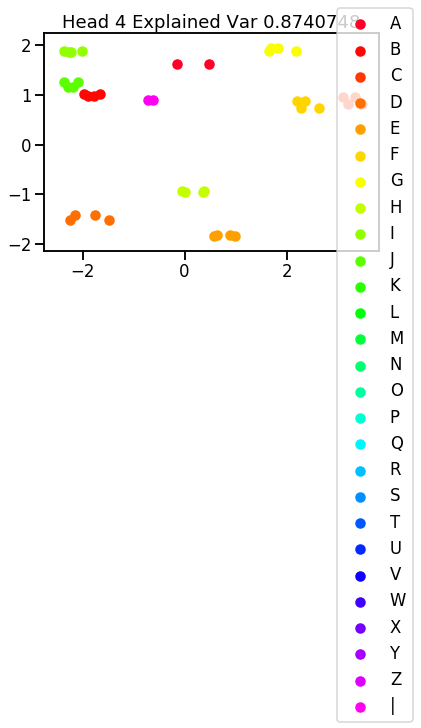

Encoder


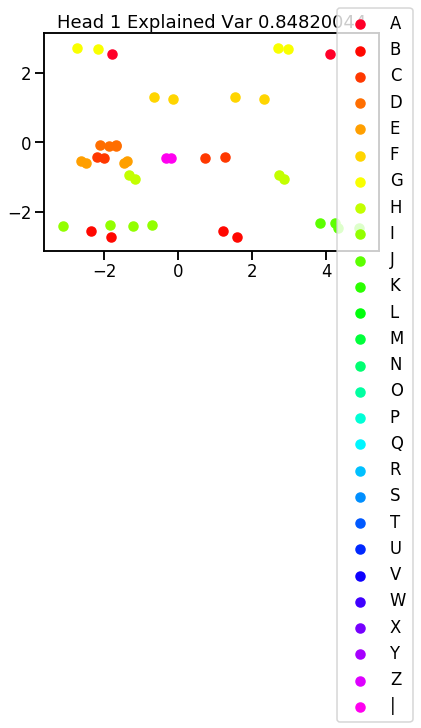

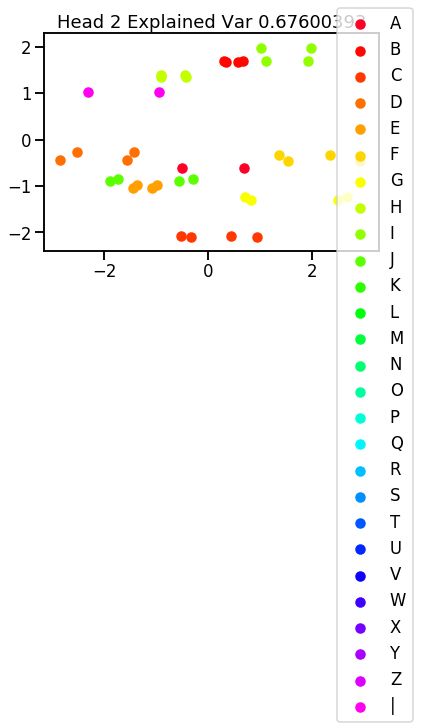

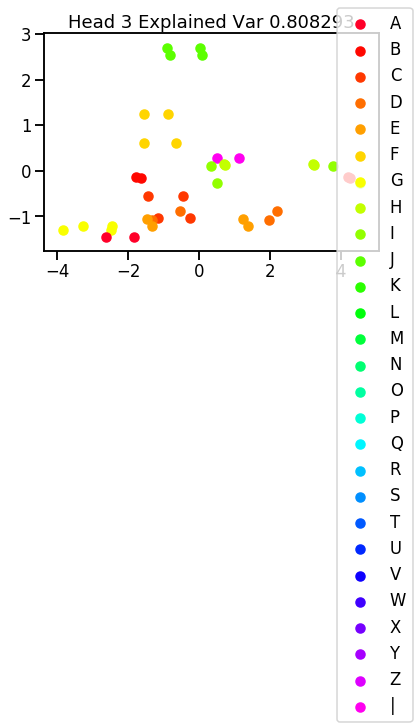

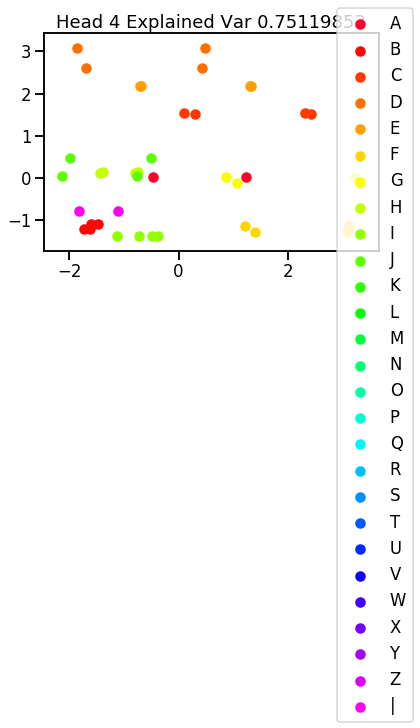

Decoder
SUM 1.0


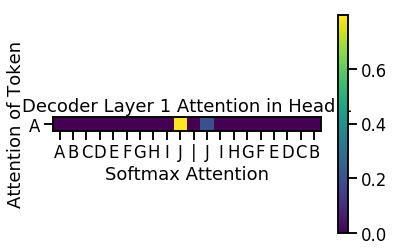

SUM 1.0


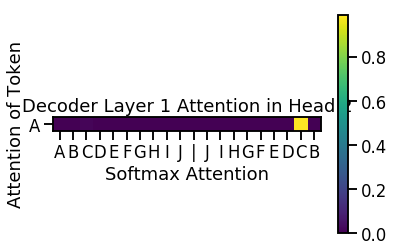

SUM 1.0


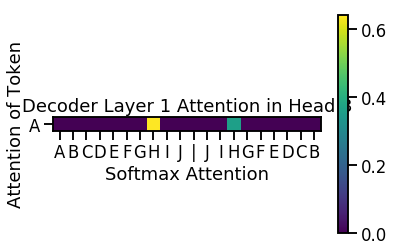

SUM 1.0


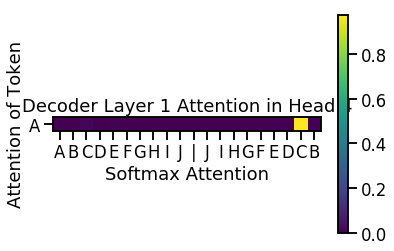

Decoder
SUM 1.0


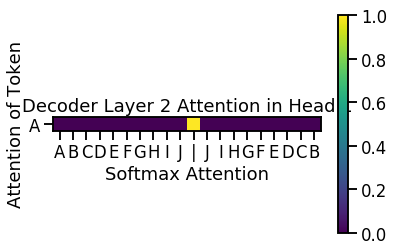

SUM 0.99999994


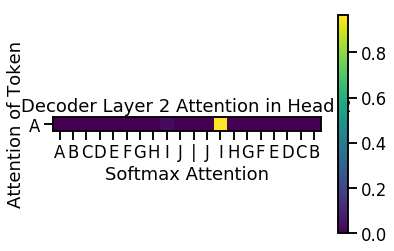

SUM 0.99999994


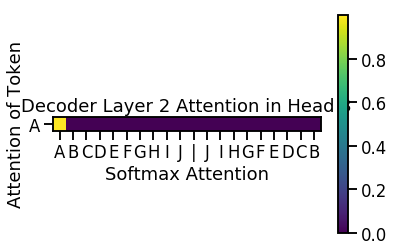

SUM 0.99999994


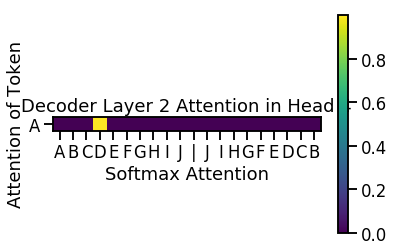

In [58]:
source_text = 'A B C D E F G H I J | J I H G F E D C B'
src, tgt, k, remember_text, forget_text = generate_data_from_source(source_text)
print(src)
model.eval()

if transition_type == 'explicit' or transition_type == 'repeated':
    src_length = 2*k
else:
    src_length = 2*k - 1
        
true = tgt[1].item()
        
src_mask = (src != len(vocabulary)).unsqueeze(-2)
out = tr.greedy_decode(model, src, src_mask, max_len=2, start_symbol=len(vocabulary))

encoder_output = model.encode(src, src_mask)

pred = vocabulary[out[0][1].item()]
    
encoder_layers = model.encoder.layers
for lyr, encoder in enumerate(encoder_layers):
    print('Encoder')
    for head in range(num_heads):
        q = encoder.self_attn.queries[0,head,:,:].detach().numpy()
        k = encoder.self_attn.keys[0,head,:,:].detach().numpy()
        v = encoder.self_attn.values[0,head,:,:].detach().numpy()
        
        pca_h = PCA()
        pca_h.fit(np.vstack((q[:src_length,:],k[:src_length,:])))
        
        pca_q = pca_h.transform(q[:src_length,:])
        pca_k = pca_h.transform(k[:src_length,:])
        
        fig, ax = set_color_cycle()
        var = np.sum(pca_h.explained_variance_ratio_[:2])
        ax.set_title('Head '+str(head+1)+' Explained Var '+str(var))
        
        
        for idx in range(len(vocabulary)):
            relevant_indices = np.where(src[0].numpy() == idx)[0]
            ax.scatter(pca_q[relevant_indices,0], pca_q[relevant_indices,1], label=vocabulary[idx])
        for idx in range(len(vocabulary)):
            relevant_indices = np.where(src[0].numpy() == idx)[0]
            ax.scatter(pca_k[relevant_indices,0], pca_q[relevant_indices,1])
        fig.legend()
        plt.show()

decoder_layers = model.decoder.layers
for lyr, decoder in enumerate(decoder_layers):
    print('Decoder')
#     print(decoder.src_attn.attn.shape)
#     print(decoder.src_attn.attn[:,0,0, :src_length].detach().numpy())
    for head in range(num_heads):
        plt.title('Decoder Layer '+str(lyr+1)+' Attention in Head '+str(head+1))
        print('SUM',np.sum(decoder.src_attn.attn[:,head,0, :src_length].detach().numpy()))
        plt.imshow(decoder.src_attn.attn[:,head,0, :src_length].detach().numpy(), origin='lower')
        plt.xticks(range(src_length), list(source_text.split(' ')))
        plt.yticks(range(1), [vocabulary[tgt.numpy()[1]]])
        plt.ylabel('Attention of Token')
        plt.xlabel('Softmax Attention')
        plt.colorbar()
        plt.show()
    
# Dataset L2 Accuracy: 92.3%
# Dataset L3 Accuracy: 70.45%
# Dataset L4 Accuracy: 65.8%
# Dataset L5 Accuracy: 60.9%
# Dataset L6 Accuracy: 58.0%
# Dataset L7 Accuracy: 53.25%
# Dataset L8 Accuracy: 48.5%
# Dataset L9 Accuracy: 43.8%
# Dataset L10 Accuracy: 38.35%

The shape of attention is always `[1, #heads, #tokens, #tokens]`

The shape of projected vectors is `[1, #heads, #tokens, #d_model/#heads]`

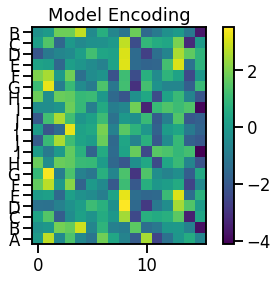

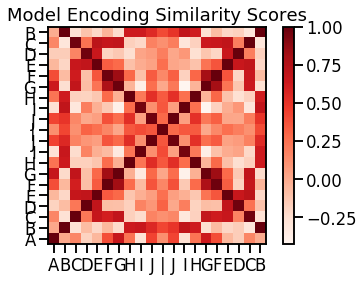

In [59]:
relevant_encoding = encoder_output[0].detach().numpy()[:src_length,:]
plt.title('Model Encoding')
plt.imshow(relevant_encoding, origin='lower')
plt.yticks(range(src_length), remember_text + ['|']+forget_text)
plt.colorbar()
plt.show()

similarity = np.zeros((src_length, src_length))
for i, A in enumerate(relevant_encoding):
    for j, B in enumerate(relevant_encoding):
        similarity[i,j] = cosine_similarity(A,B)

plt.title('Model Encoding Similarity Scores')
plt.imshow(similarity, origin='lower',cmap='Reds')
plt.yticks(range(src_length), remember_text + ['|']+forget_text)
plt.xticks(range(src_length), remember_text + ['|']+forget_text)
plt.colorbar()
plt.show()

We will now test to see if the representation that is being learned is irrelevant to the position but rather specific to the character. In otherwords, is the representation from the encoder the same over a character regardless of whether it occurs in the forget or remember step (i.e. is the transformer encoding the text into character manifolds?)

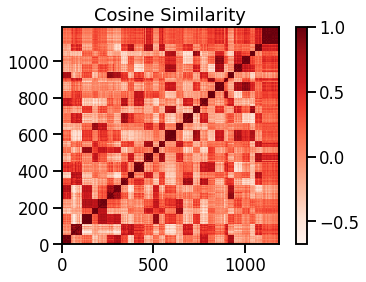

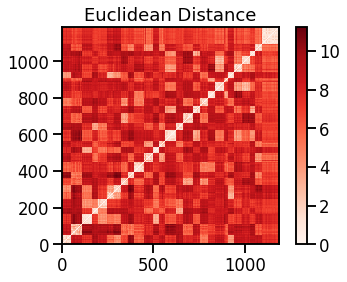

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '|']


In [60]:
character_examples = {}
num_samples = 100
for samp in range(num_samples):
    src, tgt, k, remember_text, forget_text = data_sample(vocabulary, Ks = range(2,11), verbose=True)
    model.eval()

    if transition_type == 'explicit' or transition_type == 'repeated':
        src_length = 2*k
    else:
        src_length = 2*k - 1

    true = tgt[1].item()

    src_mask = (src != len(vocabulary)).unsqueeze(-2)
    out = tr.greedy_decode(model, src, src_mask, max_len=2, start_symbol=len(vocabulary))

    encoder_output = model.encode(src, src_mask)[0]

    for char_idx, char in enumerate(remember_text):
        if char not in character_examples:
            character_examples[char] = []

        character_examples[char].append(encoder_output[char_idx, :].detach().numpy())

    if '|' not in character_examples:
        character_examples['|'] = []
    character_examples['|'].append(encoder_output[len(remember_text), :].detach().numpy())

    for char_idx, char in enumerate(forget_text):
        if char not in character_examples:
            character_examples[char] = []
        character_examples[char].append(encoder_output[char_idx + len(remember_text) + 1, :].detach().numpy())

character_encoding = None
text = []
for char in sorted(character_examples.keys()):
    text = text + [char]*len(character_examples[char])
    if character_encoding is None:
        character_encoding = np.array(character_examples[char])
    else:
        character_encoding = np.vstack((character_encoding, np.array(character_examples[char])))

similarity = np.zeros((len(character_encoding), len(character_encoding)))
distance = np.zeros((len(character_encoding), len(character_encoding)))
for i, A in enumerate(character_encoding):
    for j, B in enumerate(character_encoding):
        similarity[i,j] = cosine_similarity(A,B)
        distance[i,j] = np.linalg.norm(A-B)
plt.title('Cosine Similarity')      
plt.imshow(similarity,origin='lower', cmap='Reds')
# plt.xticks(text)
# plt.yticks(text)
plt.colorbar()
plt.show()
plt.close()

plt.title('Euclidean Distance')      
plt.imshow(distance,origin='lower', cmap='Reds')
# plt.xticks(text)
# plt.yticks(text)
plt.colorbar()
plt.show()
print(sorted(character_examples.keys()))



In [61]:
dims, std, npoints = idims.block_analysis(distance)
print('Average dimensionality',dims.mean())
print('With average std',std.mean())

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


Average dimensionality 3.03939671129692
With average std 0.36864599640814966


Look at weigths that merge heads so you get 4 x 16 matrix for each head (in dmodel 16 with 4 heads)
Only look forward encoder mask
Diagnostic classifier on hidden representations (zs)

Do the same plot as above for GRUS

The following code generates the manifold analysis for the transformer

In [34]:
manifolds_over_layer = {'Embedding':{}}

manifolds_over_component = {'Embedding':{}}
num_samples = 1000

for lyr in range(num_layers):
    manifolds_over_layer['Decoder '+str(lyr+1)] = {}
    manifolds_over_layer['Encoder '+str(lyr+1)] = {}
    
    manifolds_over_component['Encoder '+str(lyr+1)+' Self Attention'] = {}
    
    manifolds_over_component['Decoder '+str(lyr+1)+' Self Attention'] = {}
    manifolds_over_component['Decoder '+str(lyr+1)+' Enc-Dec Attention'] = {}
    
for samp in range(num_samples):
    src, tgt, k, remember_text, forget_text = data_sample(vocabulary, Ks = range(2,11), verbose=True)
    model.eval()

    if transition_type == 'explicit' or transition_type == 'repeated':
        src_length = 2*k
    else:
        src_length = 2*k - 1

    true_tgt = tgt[1].item()

    src_mask = (src != len(vocabulary)).unsqueeze(-2)
    out = tr.greedy_decode(model, src, src_mask, max_len=2, start_symbol=len(vocabulary))
    
    
    embeddings = model.src_embed(src)[0]
    
    relevant_token_indices = {}
    for token in range(len(vocabulary) + 1):
        relevant_indices = np.where(src[0] == token)[0]
        relevant_token_indices[token] = relevant_indices
        
        if token in manifolds_over_layer['Embedding']:
            manifolds_over_layer['Embedding'][token] = \
            np.vstack((manifolds_over_layer['Embedding'][token], embeddings.detach().numpy()[relevant_indices,:]))
        else:
            manifolds_over_layer['Embedding'][token] = embeddings.detach().numpy()[relevant_indices,:]
    
    encoder_layers = model.encoder.layer_outputs
    for lyr in range(len(encoder_layers)):
        z_lyr = encoder_layers[lyr][0]
        
        for token in range(len(vocabulary) + 1):
            relevant_indices = relevant_token_indices[token]
        
            if token in manifolds_over_layer['Encoder '+str(lyr+1)]:
                manifolds_over_layer['Encoder '+str(lyr+1)][token] = \
                np.vstack((manifolds_over_layer['Encoder '+str(lyr+1)][token], z_lyr.detach().numpy()[relevant_indices,:]))
            else:
                manifolds_over_layer['Encoder '+str(lyr+1)][token] = z_lyr.detach().numpy()[relevant_indices,:]
    decoder_layers = model.decoder.layer_outputs
    for lyr in range(len(decoder_layers)):
        z_lyr = decoder_layers[lyr][0]
        
        if token in manifolds_over_layer['Decoder '+str(lyr+1)]:
            manifolds_over_layer['Decoder '+str(lyr+1)][true_tgt] = \
            np.vstack((manifolds_over_layer['Decoder '+str(lyr+1)][true_tgt], z_lyr.detach().numpy()))
        else:
            manifolds_over_layer['Decoder '+str(lyr+1)][true_tgt] = z_lyr.detach().numpy() 
            
            

In [37]:
# Embeddings
a_ms = []
r_ms = []
d_ms = []
res = []
kks = []

print('Embedding Manifolds')
embedding_manifolds = []
for token in range(len(vocabulary) + 1):
    embedding_manifolds.append(manifolds_over_layer['Embedding'][token].T)

a_Mfull_vec, R_M_vec, D_M_vec, res_coeff0, KK = manifold_analysis_corr(embedding_manifolds, 0.001, 10)  

a_ms.append(a_Mfull_vec)
r_ms.append(R_M_vec)
d_ms.append(D_M_vec)
res.append(res_coeff0)
kks.append(KK)

for lyr in range(num_layers):
    print('Encoder '+str(lyr+1)+' Manifolds')
    this_manifolds = []
    for token in range(len(vocabulary) + 1):
        this_manifolds.append(manifolds_over_layer['Encoder '+str(lyr+1)][token].T)

    a_Mfull_vec, R_M_vec, D_M_vec, res_coeff0, KK = manifold_analysis_corr(this_manifolds, 0.001, 10)
    
    a_ms.append(a_Mfull_vec)
    r_ms.append(R_M_vec)
    d_ms.append(D_M_vec)
    res.append(res_coeff0)
    kks.append(KK)

for lyr in range(num_layers):
    print('Decoder '+str(lyr+1)+' Manifolds')
    this_manifolds = []
    for token in range(len(vocabulary) + 1):
        if token in manifolds_over_layer['Decoder '+str(lyr+1)]:
            this_manifolds.append(manifolds_over_layer['Decoder '+str(lyr+1)][token].T)

    a_Mfull_vec, R_M_vec, D_M_vec, res_coeff0, KK = manifold_analysis_corr(this_manifolds, 0.001, 10)
    
    a_ms.append(a_Mfull_vec)
    r_ms.append(R_M_vec)
    d_ms.append(D_M_vec)
    res.append(res_coeff0)
    kks.append(KK)

Embedding Manifolds
Encoder 1 Manifolds
Encoder 2 Manifolds
Decoder 1 Manifolds
Decoder 2 Manifolds


Hidden State (z's) manifolds


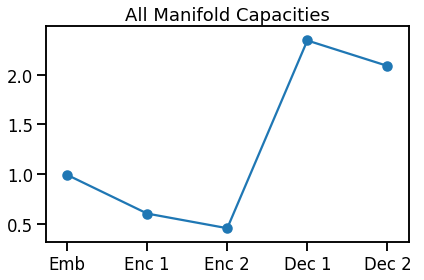

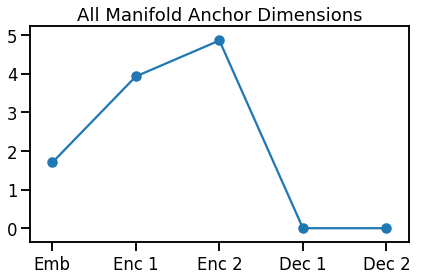

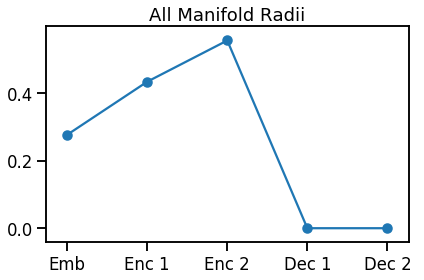

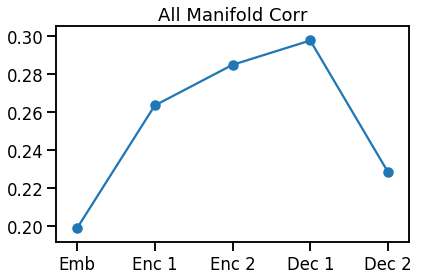

In [48]:
caps = []
for arr in a_ms:
    caps.append(1/np.mean(1/arr))

dims = []
for arr in d_ms:
    dims.append(np.mean(arr))
    
rads = []
for arr in r_ms:
    rads.append(np.mean(arr))

kk_np = np.array(kks)

# Including Empty Character
print("Hidden State (z's) manifolds")
plt.title('All Manifold Capacities')
plt.plot(caps)
plt.scatter(range(len(caps)),caps)
plt.xticks(range(len(caps)), ['Emb', 'Enc 1', 'Enc 2', 'Dec 1', 'Dec 2'])
plt.tight_layout()
plt.show()

plt.title('All Manifold Anchor Dimensions')
plt.plot(dims)
plt.scatter(range(len(dims)), dims)
plt.xticks(range(len(dims)), ['Emb', 'Enc 1', 'Enc 2', 'Dec 1', 'Dec 2'])
plt.tight_layout()
plt.show()

plt.title('All Manifold Radii')
plt.plot(rads)
plt.scatter(range(len(rads)), rads)
plt.xticks(range(len(rads)), ['Emb', 'Enc 1', 'Enc 2', 'Dec 1', 'Dec 2'])
plt.tight_layout()
plt.show()

plt.title('All Manifold Corr')
plt.plot(res)
plt.scatter(range(len(res)), res)
plt.xticks(range(len(res)), ['Emb', 'Enc 1', 'Enc 2', 'Dec 1', 'Dec 2'])
plt.tight_layout()
plt.show()


In [49]:
model_0 = tr.make_transformer(src_vocab=len(vocabulary)+1, \
                        tgt_vocab=len(vocabulary)+1, \
                        N=num_layers, \
                        d_model=hidden_size, \
                        d_ff=4*hidden_size, \
                        h=num_heads, \
                        dropout=0.0)

In [50]:
manifolds_over_layer_0 = {'Embedding':{}}

manifolds_over_component_0 = {'Embedding':{}}
num_samples = 1000

for lyr in range(num_layers):
    manifolds_over_layer_0['Decoder '+str(lyr+1)] = {}
    manifolds_over_layer_0['Encoder '+str(lyr+1)] = {}
    
    manifolds_over_component_0['Encoder '+str(lyr+1)+' Self Attention'] = {}
    
    manifolds_over_component_0['Decoder '+str(lyr+1)+' Self Attention'] = {}
    manifolds_over_component_0['Decoder '+str(lyr+1)+' Enc-Dec Attention'] = {}
    
for samp in range(num_samples):
    src, tgt, k, remember_text, forget_text = data_sample(vocabulary, Ks = range(2,11), verbose=True)
    model_0.eval()

    if transition_type == 'explicit' or transition_type == 'repeated':
        src_length = 2*k
    else:
        src_length = 2*k - 1

    true_tgt = tgt[1].item()

    src_mask = (src != len(vocabulary)).unsqueeze(-2)
    out = tr.greedy_decode(model_0, src, src_mask, max_len=2, start_symbol=len(vocabulary))
    
    
    embeddings = model_0.src_embed(src)[0]
    
    relevant_token_indices = {}
    for token in range(len(vocabulary) + 1):
        relevant_indices = np.where(src[0] == token)[0]
        relevant_token_indices[token] = relevant_indices
        
        if token in manifolds_over_layer_0['Embedding']:
            manifolds_over_layer_0['Embedding'][token] = \
            np.vstack((manifolds_over_layer_0['Embedding'][token], embeddings.detach().numpy()[relevant_indices,:]))
        else:
            manifolds_over_layer_0['Embedding'][token] = embeddings.detach().numpy()[relevant_indices,:]
    
    encoder_layers = model_0.encoder.layer_outputs
    for lyr in range(len(encoder_layers)):
        z_lyr = encoder_layers[lyr][0]
        
        for token in range(len(vocabulary) + 1):
            relevant_indices = relevant_token_indices[token]
        
            if token in manifolds_over_layer_0['Encoder '+str(lyr+1)]:
                manifolds_over_layer_0['Encoder '+str(lyr+1)][token] = \
                np.vstack((manifolds_over_layer_0['Encoder '+str(lyr+1)][token], z_lyr.detach().numpy()[relevant_indices,:]))
            else:
                manifolds_over_layer_0['Encoder '+str(lyr+1)][token] = z_lyr.detach().numpy()[relevant_indices,:]
    decoder_layers = model_0.decoder.layer_outputs
    for lyr in range(len(decoder_layers)):
        z_lyr = decoder_layers[lyr][0]
        
        if token in manifolds_over_layer_0['Decoder '+str(lyr+1)]:
            manifolds_over_layer_0['Decoder '+str(lyr+1)][true_tgt] = \
            np.vstack((manifolds_over_layer_0['Decoder '+str(lyr+1)][true_tgt], z_lyr.detach().numpy()))
        else:
            manifolds_over_layer_0['Decoder '+str(lyr+1)][true_tgt] = z_lyr.detach().numpy() 
            
            

In [51]:
# Embeddings
a_ms_0 = []
r_ms_0 = []
d_ms_0 = []
res_0 = []
kks_0 = []

print('Embedding Manifolds')
embedding_manifolds_0 = []
for token in range(len(vocabulary) + 1):
    embedding_manifolds_0.append(manifolds_over_layer_0['Embedding'][token].T)

a_Mfull_vec, R_M_vec, D_M_vec, res_coeff0, KK = manifold_analysis_corr(embedding_manifolds_0, 0.001, 10)  

a_ms_0.append(a_Mfull_vec)
r_ms_0.append(R_M_vec)
d_ms_0.append(D_M_vec)
res_0.append(res_coeff0)
kks_0.append(KK)

for lyr in range(num_layers):
    print('Encoder '+str(lyr+1)+' Manifolds')
    this_manifolds = []
    for token in range(len(vocabulary) + 1):
        this_manifolds.append(manifolds_over_layer_0['Encoder '+str(lyr+1)][token].T)

    a_Mfull_vec, R_M_vec, D_M_vec, res_coeff0, KK = manifold_analysis_corr(this_manifolds, 0.001, 10)
    
    a_ms_0.append(a_Mfull_vec)
    r_ms_0.append(R_M_vec)
    d_ms_0.append(D_M_vec)
    res_0.append(res_coeff0)
    kks_0.append(KK)

for lyr in range(num_layers):
    print('Decoder '+str(lyr+1)+' Manifolds')
    this_manifolds = []
    for token in range(len(vocabulary) + 1):
        if token in manifolds_over_layer_0['Decoder '+str(lyr+1)]:
            this_manifolds.append(manifolds_over_layer_0['Decoder '+str(lyr+1)][token].T)

    a_Mfull_vec, R_M_vec, D_M_vec, res_coeff0, KK = manifold_analysis_corr(this_manifolds, 0.001, 10)
    
    a_ms_0.append(a_Mfull_vec)
    r_ms_0.append(R_M_vec)
    d_ms_0.append(D_M_vec)
    res_0.append(res_coeff0)
    kks_0.append(KK)

print('Finished')

Embedding Manifolds
Encoder 1 Manifolds
Encoder 2 Manifolds
Decoder 1 Manifolds
Decoder 2 Manifolds


Hidden State (z's) manifolds


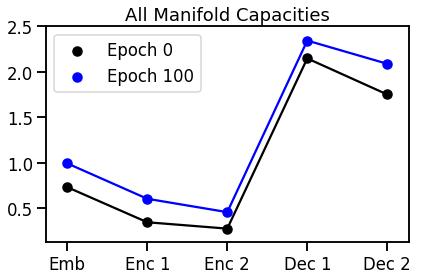

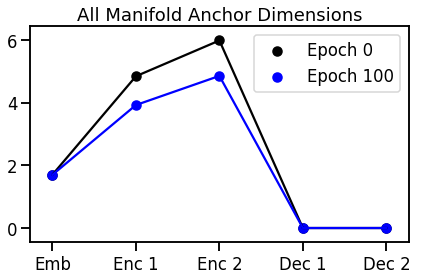

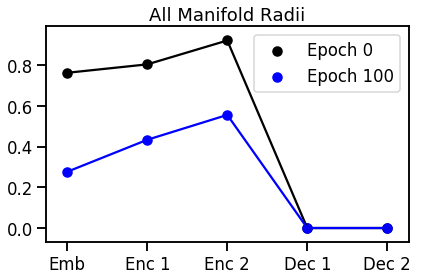

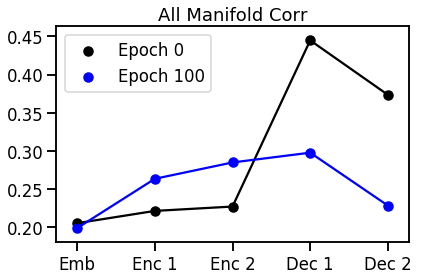

In [57]:
caps_0 = []
for arr in a_ms_0:
    caps_0.append(1/np.mean(1/arr))

dims_0 = []
for arr in d_ms_0:
    dims_0.append(np.mean(arr))
    
rads_0 = []
for arr in r_ms_0:
    rads_0.append(np.mean(arr))

kk_np_0 = np.array(kks_0)

# Including Empty Character
print("Hidden State (z's) manifolds")
plt.title('All Manifold Capacities')
plt.plot(caps_0, color='black')
plt.scatter(range(len(caps_0)),caps_0, color='black', label='Epoch 0')
plt.plot(caps, color='blue')
plt.scatter(range(len(caps)),caps, color='blue', label='Epoch 100')
plt.xticks(range(len(caps_0)), ['Emb', 'Enc 1', 'Enc 2', 'Dec 1', 'Dec 2'])
plt.tight_layout()
plt.legend()
plt.show()

plt.title('All Manifold Anchor Dimensions')
plt.plot(dims_0, color='black')
plt.scatter(range(len(dims_0)), dims_0, color='black', label='Epoch 0')
plt.plot(dims, color='blue')
plt.scatter(range(len(dims)), dims, color='blue', label='Epoch 100')
plt.xticks(range(len(dims_0)), ['Emb', 'Enc 1', 'Enc 2', 'Dec 1', 'Dec 2'])
plt.tight_layout()
plt.legend()
plt.show()

plt.title('All Manifold Radii')
plt.plot(rads_0, color='black')
plt.scatter(range(len(rads_0)), rads_0, color='black', label='Epoch 0')
plt.plot(rads, color='blue')
plt.scatter(range(len(rads)), rads, color='blue', label='Epoch 100')
plt.xticks(range(len(rads_0)), ['Emb', 'Enc 1', 'Enc 2', 'Dec 1', 'Dec 2'])
plt.tight_layout()
plt.legend()
plt.show()

plt.title('All Manifold Corr')
plt.plot(res_0, color='black')
plt.scatter(range(len(res_0)), res_0, color='black', label='Epoch 0')
plt.plot(res, color='blue')
plt.scatter(range(len(res)), res, color='blue', label='Epoch 100')
plt.xticks(range(len(res_0)), ['Emb', 'Enc 1', 'Enc 2', 'Dec 1', 'Dec 2'])
plt.tight_layout()
plt.legend()
plt.show()

[0.27644249522776737, 0.43345179049683263, 0.5554011886671089, 0.0, 0.0]